Lab02
============

# Objective

분류기법 중 하나인 회귀에 기반한 모델 Logistic Regression을 이해하고 사용하는 것 입니다



# Logistic Regression


Logistic Regression은 클래스 분류문제를 해결하기 위해 회귀를 사용한 방법입니다

독립 변수의 선형 결합으로 종속 변수를 설명하는 부분은 선형 회귀(Linear Regression)와 같으나,

모델의 결과물로써 특정 클래스로 분류될 확률이 나오기 때문에 분류문제를 수행할 수 있는 방법입니다.

## odds
어떤 일이 발생할 **상대적인** 비율을 말합니다
<br><br>
발생할 확률 $p$ 와 발생하지 않을 확률 $q = 1-p$ 에 대해 두 확률의 상대적인 비율을 정의하면 아래와 같습니다

![title](Images/ODD_F.png)

## Log(odds)

1. 0을 기준으로 상호 대칭적
2. 계산이 용이

![title](Images/ODD_G.png)

## Logistic Function(sigmoid)
해당 클래스일 확률 Y를 Log(odds)로 보고 이를 유도해보겠습니다

![title](Images/sigmoid_F1.png)

![title](Images/sigmoid_F2.png)

위에 정리된 식을 가설 그래프로 나타내면

![title](Images/sigmoid_G.png)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from scipy import optimize as op
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp

# 1. 데이터 살펴보기
앞서 사용했던 붓꽃 데이터를 사용합니다.

독립 변수로는 꽃받침 길이, 꽃받침 너비, 꽃잎의 길이, 꽃잎의 너비 데이터가 종속 변수로는 붓꽃 종(Species)입니다.

In [2]:
iris_analysis = pd.read_csv(join('data', 'Iris.csv'))

iris_analysis.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
iris_setosa = iris_analysis.loc[iris_analysis['Species'] == 'Iris-setosa']
iris_versicolor = iris_analysis.loc[iris_analysis['Species'] == 'Iris-versicolor']
iris_virginica = iris_analysis.loc[iris_analysis['Species'] == 'Iris-virginica']

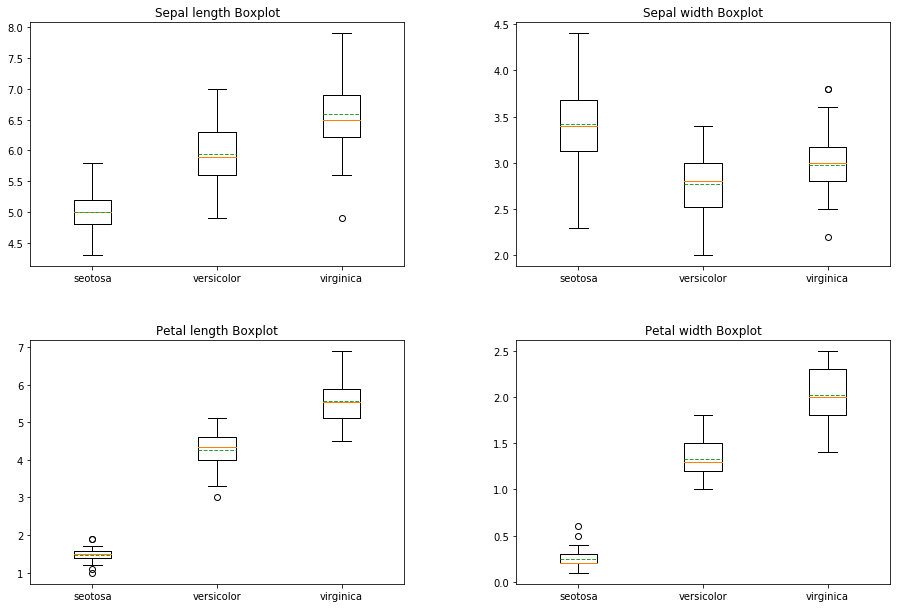

In [4]:
fig, axs = plt.subplots(2,2)

#꽃받침의 길이
axs[0, 0].boxplot([iris_setosa['SepalLengthCm'], iris_versicolor['SepalLengthCm'], iris_virginica['SepalLengthCm']],
           labels = ['seotosa', 'versicolor', 'virginica'],
           meanline = True,
           showmeans = True)
axs[0, 0].set_title('Sepal length Boxplot')

#꽃받침의 너비
axs[0, 1].boxplot([iris_setosa['SepalWidthCm'], iris_versicolor['SepalWidthCm'], iris_virginica['SepalWidthCm']],
           labels = ['seotosa', 'versicolor', 'virginica'],
           meanline = True,
           showmeans = True)
axs[0, 1].set_title('Sepal width Boxplot')

#꽃잎의 길이
axs[1, 0].boxplot([iris_setosa['PetalLengthCm'], iris_versicolor['PetalLengthCm'], iris_virginica['PetalLengthCm']],
           labels = ['seotosa', 'versicolor', 'virginica'],
           meanline = True,
           showmeans = True)
axs[1, 0].set_title('Petal length Boxplot')

#꽃잎의 너비
axs[1, 1].boxplot([iris_setosa['PetalWidthCm'], iris_versicolor['PetalWidthCm'], iris_virginica['PetalWidthCm']],
           labels = ['seotosa', 'versicolor', 'virginica'],
           meanline = True,
           showmeans = True)
axs[1, 1].set_title('Petal width Boxplot')

fig.subplots_adjust(left = 0.01, right = 2, bottom = 0.05, top = 2, hspace = 0.3, wspace = 0.3)

plt.show()

In [5]:
iris = pd.read_csv(join('data', 'Iris.csv'))
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# 2. 간단한 전처리
모든 독립 변수와 별개로 상수항을 추가하기 위해 ones함수를 이용하여 하나의 열을 추가하고 나머지 데이터를 다시 제자리에 저장합니다.

학습용 데이터와 테스트용 데이터를 7:3의 비율로 나눕니다.

In [6]:
Species = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

#데이터의 수
m = iris.shape[0]

#독립 변수의 수
n = 4
k = len(Species)


X = np.ones((m,n + 1))
# y = np.zeros((m,k))

for q,i in enumerate(iris.keys()[1:5]):
    X[:,q]=iris[i].values

y=iris.Species.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

# 3. scratch로 분류 해보기

### sigmoid
위의 유도한 Logistic Function으로 z에 독립 변수와 계수의 스칼라곱을 수행하여 활용할 함수입니다.

In [7]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

### 비용함수
실제 값과 모델의 연산으로 추정된 값 간의 차를 연산해주는 함수를 말합니다

이 비용함수를 최소화하는 계수들(theta)을 찾는 것이 Logistic Regression의 목표입니다. 

이 함수를 최소화 하기 위해 경사하강법을 사용하는데 이론 수업에서 자세히 다루지 않으므로 간략하게 정리해두었습니다

![title](Images/LRC_F.png)

![title](Images/LRG_F.png)

In [8]:
def regCostFunction(theta, X, y, _lambda = 0.1):
    m = len(X)
    h = sigmoid(X.dot(theta))
    reg = (_lambda/(2 * m)) * np.sum(theta**2)

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg

def regGradient(theta, X, y, _lambda = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    reg = _lambda * theta /m

    return ((1 / m) * X.T.dot(h - y)) + reg

### logisticRegression(X, y, theta)
위의 비용함수를 최소화하기위해 scipy의 optimize.minimize를 이용하겠습니다

op.minimize의 인수로써 X에는 학습용 데이터, y에는 학습용 데이터의 답, 

theta에는 초기 계수들의 집합을 넣어 최적화된 계수, 마지막으로 비용함수에 대한 것들을 채워넣겠습니다

In [9]:
def logisticRegression(X, y, theta):
    result = op.minimize(fun = regCostFunction, x0 = theta, args = (X, y),
                         method = 'TNC', jac = regGradient)
    
    return result.x

In [10]:
#계수를 저장할 변수
all_theta = np.zeros((len(np.unique(y)), n + 1))
cols=[i for i in iris.keys()[1:5]]+['bias']
#학습 수행
i = 0
for flower in Species:
#     print(flower)
    #현재 구하고자하는 종은 1 아닌 값은 0
    tmp_y = np.array(y_train == flower, dtype = int)
    optTheta = logisticRegression(X_train, tmp_y, np.zeros((n + 1,1)))
    for l,q in enumerate(optTheta):
        print("%s's theta %s = %.4f"%(flower,cols[l],q))
    all_theta[i] = optTheta
    i += 1
    
# print(all_theta)

Iris-setosa's theta SepalLengthCm = 0.5199
Iris-setosa's theta SepalWidthCm = 2.2659
Iris-setosa's theta PetalLengthCm = -3.2788
Iris-setosa's theta PetalWidthCm = -1.5619
Iris-setosa's theta bias = 0.3109
Iris-versicolor's theta SepalLengthCm = 0.7498
Iris-versicolor's theta SepalWidthCm = -3.5083
Iris-versicolor's theta PetalLengthCm = 0.7121
Iris-versicolor's theta PetalWidthCm = -2.3413
Iris-versicolor's theta bias = 5.4996
Iris-virginica's theta SepalLengthCm = -3.2423
Iris-virginica's theta SepalWidthCm = -2.5692
Iris-virginica's theta PetalLengthCm = 4.5619
Iris-virginica's theta PetalWidthCm = 5.0677
Iris-virginica's theta bias = -3.0829


In [11]:
#추론부분
P = sigmoid(X_test.dot(all_theta.T)) #각 종에 대한 모든 데이터의 확률값
p = [Species[np.argmax(P[i, :])] for i in range(X_test.shape[0])] #추론된 확률 중 가장 높은 값을 채택하여 그 종으로 최종 추론

print("테스트 세트 정확도:", accuracy_score(y_test, p) * 100 , '%')

테스트 세트 정확도: 88.88888888888889 %


# 4. scratch로 분류한 결과 확인하기
분류 값과 실제 값을 Confusion Matrix로 시각화 해보겠습니다

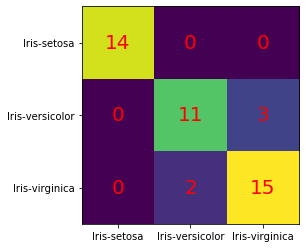

In [12]:
cfm = confusion_matrix(y_test, p, labels = Species)

fig, ax = plt.subplots()
im = ax.imshow(cfm)

ax.set_xticks(np.arange(len(Species)))
ax.set_yticks(np.arange(len(Species)))

ax.set_xticklabels(Species)
ax.set_yticklabels(Species)

for i in range(len(Species)):
    for j in range(len(Species)):
        text = ax.text(j, i, cfm[i, j],
                       ha="center", va="center", color="r", fontsize=20)

plt.show()

# 5. sklearn으로 분류해보기

이제 Scikit-learn을 사용하여 Logistic Regression을 시도해보겠습니다

LogisticRegression이라는 오브젝트로 모델을 사용하실 수 있습니다

또한 이번에도 붓꽃 데이터의 전부를 사용하여 학습하고 테스트해보세요

In [20]:
iris = datasets.load_iris()
X = iris.data[:,:]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

In [21]:
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [30]:
thetas=logreg.coef_
for n1,flower in enumerate(Species):
    the=thetas[n1,:]
    for n2,q in enumerate(the):
        print("%s's theta %s = %.4f"%(flower,iris_analysis.keys()[n2+1],the[n2]))


Iris-setosa's theta SepalLengthCm = 15.4743
Iris-setosa's theta SepalWidthCm = 28.1001
Iris-setosa's theta PetalLengthCm = -34.8301
Iris-setosa's theta PetalWidthCm = -23.1325
Iris-versicolor's theta SepalLengthCm = -3.8848
Iris-versicolor's theta SepalWidthCm = 10.2608
Iris-versicolor's theta PetalLengthCm = -3.1214
Iris-versicolor's theta PetalWidthCm = -49.1327
Iris-virginica's theta SepalLengthCm = -11.5895
Iris-virginica's theta SepalWidthCm = -38.3609
Iris-virginica's theta PetalLengthCm = 37.9515
Iris-virginica's theta PetalWidthCm = 72.2652


In [16]:
print("학습 세트 정확도: {:.3f}%".format(logreg.score(X_train, y_train) * 100))
print("테스트 세트 정확도: {:.3f}%".format(logreg.score(X_test, y_test) * 100))

학습 세트 정확도: 100.000%
테스트 세트 정확도: 95.556%


In [17]:
iris = datasets.load_iris()
X = iris.data[:,:]
y = iris.target

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter = 1000)

y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=11)

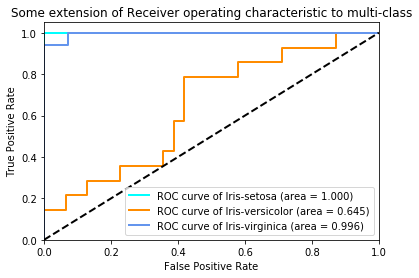

In [18]:
n_samples, n_features = X.shape

colors = (['aqua', 'darkorange', 'cornflowerblue'])

classifier = OneVsRestClassifier(logreg)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.3f})'.format(Species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
